##GPT-2 From Scratch

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
import os
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import matplotlib.pyplot as plt
import numpy as np

# GPT-2 Implementation

In [3]:
class Config():
  model_size = "small"

  if model_size == "small":
    vocab_size = 32000
    n_layer = 12
    n_head = 12
    d_model = 768
    d_ff = 3072
  elif model_size == "medium":
    vocab_size = 32000
    n_layer = 24
    n_head = 16
    d_model = 1024
    d_ff = 4096
  elif model_size == "large":
    vocab_size = 32000
    n_layer = 36
    n_head = 20
    d_model = 1280
    d_ff = 5120

  n_embd = d_model
  dropout = 0.1
  max_seq_len = 128
  batch_size = 16
  learning_rate = 1e-5
  num_epochs = 25
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  tokenizer_path = "bpe_tokenizer.json"
  checkpoint_dir = "checkpoints"
  gradient_accumulation_steps = 4
  report_interval = 250
  block_size = 128

config = Config()

In [4]:
# loads datatset from HF library
def load_wikitext(subset="wikitext-2-raw-v1"):
  dataset = load_dataset("wikitext", subset)
  return dataset

# trains BPE on dataset
def train_bpe_tokenizer(dataset, config):
  tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
  tokenizer.pre_tokenizer = Whitespace()
  trainer = BpeTrainer(vocab_size=config.vocab_size, special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"])

  # iterates through dataset for training tokenizer
  def batch_iterator():
    for split in dataset:
      for text in dataset[split]:
        yield text['text']

  tokenizer.train_from_iterator(batch_iterator(), trainer=trainer)
  tokenizer.save(config.tokenizer_path)
  return tokenizer

# loads or creates BPE tokenizer
def load_tokenizer(config):
  if os.path.exists(config.tokenizer_path):
    return Tokenizer.from_file(config.tokenizer_path)
  else:
    dataset = load_wikitext()
    return train_bpe_tokenizer(dataset, config)

In [5]:
# dataset class for modeling tasks
# handles tokenization and padding for modelling
class WikitextDataset(Dataset):
  def __init__(self, dataset, tokenizer, max_seq_len):
    self.tokenizer = tokenizer
    self.max_seq_len = max_seq_len
    self.data = []

    for text in dataset['text']:
      if text.strip():  # skip empty strings
        self.data.append(text)

  def __len__(self):
    return len(self.data)

  # retrieves a single sample from dataset
  def __getitem__(self, idx):
    text = self.data[idx]
    encoding = self.tokenizer.encode(text)
    ids = encoding.ids

    # truncate or pad to max_seq_len
    if len(ids) > self.max_seq_len:
      ids = ids[:self.max_seq_len]
    else:
      padding_length = self.max_seq_len - len(ids)
      ids = ids + [self.tokenizer.token_to_id("[PAD]")] * padding_length

    input_ids = torch.tensor(ids[:-1], dtype=torch.long)
    target_ids = torch.tensor(ids[1:], dtype=torch.long)
    return input_ids, target_ids

In [6]:
# implements causal (unidirectional) self-attention for GPT-2
class CausalSelfAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config
    assert config.n_embd % config.n_head == 0

    # batch processing for query, key and value for all heads
    self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)

    # output projection
    self.c_proj = nn.Linear(config.n_embd, config.n_embd)
    self.c_proj.GPT_SCALE_INIT = 1

    # regularization
    self.n_head = config.n_head
    self.n_embd = config.n_embd

  # generates masking for causal attention
  def generate_square_subsequent_mask(self, sz):
    mask = (torch.triu(torch.ones((sz, sz), dtype=torch.bool), diagonal=1)).type(torch.float32)
    mask = mask.to(self.config.device)
    return mask # tensor - size (sz, sz)

  # forward pass
  def forward(self, x):
    B, T, C = x.size()

    # calculate query, key, value for all heads in batch
    qkv = self.c_attn(x)
    q, k, v = qkv.split(self.n_embd, dim=2)
    k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
    q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
    v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

    # generate and apply causal attention mask
    attn_mask = self.generate_square_subsequent_mask(x.size(1))

    # apply FlashAttention for efficiency
    y = F.scaled_dot_product_attention(q, k, v, attn_mask=attn_mask, is_causal=True) # flash attention
    y = y.transpose(1, 2).contiguous().view(B, T, C)

    # output projection
    y = self.c_proj(y)
    return y

In [7]:
# MLP class
class MLP(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
    self.gelu = nn.GELU(approximate='tanh')
    self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
    self.c_proj.GPT_SCALE_INIT = 1

  def forward(self, x):
    x = self.c_fc(x)
    x = self.gelu(x)
    x = self.c_proj(x)
    return x

In [8]:
# represents a single block of GPT-2 model
# consists of causal-self-attention layer, MLP, and layer normaliztion
class Block(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.ln1 = nn.LayerNorm(config.n_embd)
    self.attn = CausalSelfAttention(config)
    self.ln2 = nn.LayerNorm(config.n_embd)
    self.mlp = MLP(config)

  def forward(self, x):
    x = x + self.attn(self.ln1(x))
    x = x + self.mlp(self.ln2(x))
    return x

In [9]:
# implements main GPT-2 Language Model
class GPT2(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    # model components
    self.transformer = nn.ModuleDict(dict(
      wte = nn.Embedding(config.vocab_size, config.n_embd),
      wpe = nn.Embedding(config.block_size, config.n_embd),
      h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
      ln_f = nn.LayerNorm(config.n_embd),
    ))
    self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    # weight sharing scheme
    self.transformer.wte.weight = self.lm_head.weight

    # initialize model parameters
    self.apply(self._init_weights)

  # initialize weights using normal distribution
  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
      std = 0.02

      # perform standard deviation
      if hasattr(module, 'GPT_SCALE_INIT'):
        std *= (2 * self.config.n_layer) ** -0.5
      torch.nn.init.normal_(module.weight, mean=0.0, std=std)

      # initialize bias with zeros
      if module.bias is not None:
        torch.nn.init.zeros_(module.bias)

    # initialize embeddings with standard deviation
    elif isinstance(module, nn.Embedding):
      torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  # perform forward pass
  def forward(self, idx, targets=None):
    # input shape - idx is of shape (B, T)
    B, T = idx.size()
    assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"

    # create posisition embeddings
    pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
    pos_emb = self.transformer.wpe(pos)

    # get token embeddings
    tok_emb = self.transformer.wte(idx)

    # combine token and position embeddings
    x = tok_emb + pos_emb

    # pass through gpt blocks
    for block in self.transformer.h:
      x = block(x)

    # apply final layer normalization
    x = self.transformer.ln_f(x)

    # get logits and calculate loss
    logits = self.lm_head(x) # (B, T, vocab_size)
    loss = None
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

    return logits, loss

In [10]:
# training the GPT model
def train(model, train_loader, val_loader, config):
  # optimizer - AdamW with weight decay
  optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=0.01)

  # Learning Rate Scheduler - warm-up and cosine decay
  scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2) # Example schedule

  # gradient accumulation
  gradient_accumulation_steps = config.gradient_accumulation_steps

  train_losses = []
  val_losses = []

  # training Loop
  for epoch in range(config.num_epochs):
    model.train()
    total_loss = 0

    for i, (input_ids, target_ids) in enumerate(tqdm(train_loader)):
      input_ids, target_ids = input_ids.to(config.device), target_ids.to(config.device)

      # forward pass
      logits, loss = model(input_ids, targets=target_ids)

      # accumulate gradients
      loss = loss / gradient_accumulation_steps
      loss.backward()

      if (i + 1) % gradient_accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        total_loss += loss.item()

      if (i + 1) % config.report_interval == 0:
        # train loss
        avg_loss = total_loss / config.report_interval
        train_losses.append(avg_loss)
        print(f"Epoch: {epoch+1}, Step: {i+1}, Train Loss: {avg_loss:.4f}")

        model.eval()

        # validation loss
        val_loss = validate(model, val_loader, config)
        val_losses.append(val_loss)
        print(f"Epoch: {epoch+1}, Step: {i+1}, Val Loss: {val_loss:.4f}")

        # reset loss
        model.train()
        total_loss = 0

    # save model checkpoint after each epoch
    checkpoint_path = os.path.join(config.checkpoint_dir, f"model_small_epoch_{epoch + 1}.pt")
    torch.save(model.state_dict(), checkpoint_path)

  return train_losses, val_losses

# helper function for validation
def validate(model, val_loader, config):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for input_ids, target_ids in val_loader:
      input_ids, target_ids = input_ids.to(config.device), target_ids.to(config.device)
      logits, loss = model(input_ids, targets=target_ids)
      total_loss += loss.item()

  avg_loss = total_loss / len(val_loader)
  return avg_loss

In [11]:
# create loss graphs
def plot_losses(train_losses, val_losses):
  # create a figure with two subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # plot training loss on first subplot
  ax1.plot(train_losses, label="Training Loss")
  ax1.set_title("Training Loss")
  ax1.set_xlabel("Steps")
  ax1.set_ylabel("Loss")
  ax1.legend()

  # plot validation loss on second subplot
  ax2.plot(val_losses, label="Validation Loss", color='orange')
  ax2.set_title("Validation Loss")
  ax2.set_xlabel("Steps")
  ax2.set_ylabel("Loss")
  ax2.legend()

  # display plots
  plt.show()

In [12]:
# calculate perplexiy of model on test dataset
def calculate_perplexity(model, test_loader, config):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for input_ids, target_ids in test_loader:
      input_ids, target_ids = input_ids.to(config.device), target_ids.to(config.device)
      logits, loss = model(input_ids, targets=target_ids)
      total_loss += loss.item()

  avg_loss = total_loss / len(test_loader)

  # calculate perplexity using exponential of average loss
  perplexity = torch.exp(torch.tensor(avg_loss))
  return perplexity.item()

In [13]:
# generate text using GPT model
def generate_text(model, tokenizer, prompt, max_length=50, decoding_strategy="greedy", top_k=50):
  model.eval()
  input_ids = tokenizer.encode(prompt).ids
  input_ids = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(config.device)

  # generate text token by token
  for _ in range(max_length):
    with torch.no_grad():
      logits, _ = model(input_ids)

    next_token_logits = logits[:, -1, :]

    # apply decoding strategy
    if decoding_strategy == "greedy":
      next_token = torch.argmax(next_token_logits, dim=-1)

    elif decoding_strategy == "top_k":
      top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k, dim=-1)
      next_token = torch.multinomial(F.softmax(top_k_logits, dim=-1), num_samples=1).squeeze(1)
      next_token = torch.gather(top_k_indices, 1, next_token.unsqueeze(1)).squeeze(1)

    # append generated token
    input_ids = torch.cat([input_ids, next_token.unsqueeze(1)], dim=-1)

  # decode generated tokens to text
  generated_text = tokenizer.decode(input_ids.squeeze().tolist())
  return generated_text

In [14]:
# load and preprocess the dataset
dataset = load_wikitext()
tokenizer = load_tokenizer(config)

# split the dataset
train_dataset = WikitextDataset(dataset['train'], tokenizer, config.max_seq_len)
val_dataset = WikitextDataset(dataset['validation'], tokenizer, config.max_seq_len)
test_dataset = WikitextDataset(dataset['test'], tokenizer, config.max_seq_len)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [15]:
# instantiate the model
model = GPT2(config).to(config.device)

os.makedirs(config.checkpoint_dir, exist_ok=True)

# train the model
train_losses, val_losses = train(model, train_loader, val_loader, config)

 17%|█▋        | 248/1486 [00:23<01:59, 10.32it/s]

Epoch: 1, Step: 250, Train Loss: 0.3087


 17%|█▋        | 252/1486 [00:29<13:39,  1.51it/s]

Epoch: 1, Step: 250, Val Loss: 4.9247


 34%|███▎      | 498/1486 [00:52<01:26, 11.48it/s]

Epoch: 1, Step: 500, Train Loss: 0.2926


 34%|███▍      | 502/1486 [00:57<10:43,  1.53it/s]

Epoch: 1, Step: 500, Val Loss: 4.7546


 50%|█████     | 748/1486 [01:20<01:11, 10.33it/s]

Epoch: 1, Step: 750, Train Loss: 0.2845


 51%|█████     | 752/1486 [01:26<08:08,  1.50it/s]

Epoch: 1, Step: 750, Val Loss: 4.6016


 67%|██████▋   | 998/1486 [01:48<00:42, 11.47it/s]

Epoch: 1, Step: 1000, Train Loss: 0.2794


 67%|██████▋   | 1002/1486 [01:54<05:16,  1.53it/s]

Epoch: 1, Step: 1000, Val Loss: 4.4816


 84%|████████▍ | 1248/1486 [02:17<00:22, 10.35it/s]

Epoch: 1, Step: 1250, Train Loss: 0.2719


 84%|████████▍ | 1252/1486 [02:23<02:35,  1.51it/s]

Epoch: 1, Step: 1250, Val Loss: 4.4604


 17%|█▋        | 248/1486 [00:22<01:59, 10.35it/s]

Epoch: 2, Step: 250, Train Loss: 0.2582


 17%|█▋        | 252/1486 [00:28<13:44,  1.50it/s]

Epoch: 2, Step: 250, Val Loss: 4.2299


 34%|███▎      | 498/1486 [00:51<01:25, 11.53it/s]

Epoch: 2, Step: 500, Train Loss: 0.2543


 34%|███▍      | 502/1486 [00:56<10:43,  1.53it/s]

Epoch: 2, Step: 500, Val Loss: 4.1759


 50%|█████     | 748/1486 [01:19<01:11, 10.34it/s]

Epoch: 2, Step: 750, Train Loss: 0.2645


 51%|█████     | 752/1486 [01:25<08:06,  1.51it/s]

Epoch: 2, Step: 750, Val Loss: 4.1525


 67%|██████▋   | 998/1486 [01:47<00:42, 11.42it/s]

Epoch: 2, Step: 1000, Train Loss: 0.2579


 67%|██████▋   | 1002/1486 [01:53<05:18,  1.52it/s]

Epoch: 2, Step: 1000, Val Loss: 4.1475


 84%|████████▍ | 1248/1486 [02:16<00:23, 10.30it/s]

Epoch: 2, Step: 1250, Train Loss: 0.2546


 84%|████████▍ | 1252/1486 [02:22<02:36,  1.50it/s]

Epoch: 2, Step: 1250, Val Loss: 4.0815


 17%|█▋        | 248/1486 [00:22<01:59, 10.35it/s]

Epoch: 3, Step: 250, Train Loss: 0.2348


 17%|█▋        | 252/1486 [00:28<13:41,  1.50it/s]

Epoch: 3, Step: 250, Val Loss: 3.9707


 34%|███▎      | 498/1486 [00:51<01:26, 11.43it/s]

Epoch: 3, Step: 500, Train Loss: 0.2374


 34%|███▍      | 502/1486 [00:57<10:49,  1.51it/s]

Epoch: 3, Step: 500, Val Loss: 3.9355


 50%|█████     | 748/1486 [01:19<01:11, 10.35it/s]

Epoch: 3, Step: 750, Train Loss: 0.2411


 51%|█████     | 752/1486 [01:25<08:07,  1.51it/s]

Epoch: 3, Step: 750, Val Loss: 3.9093


 67%|██████▋   | 998/1486 [01:48<00:42, 11.43it/s]

Epoch: 3, Step: 1000, Train Loss: 0.2495


 67%|██████▋   | 1002/1486 [01:53<05:16,  1.53it/s]

Epoch: 3, Step: 1000, Val Loss: 3.8902


 84%|████████▍ | 1248/1486 [02:16<00:23, 10.33it/s]

Epoch: 3, Step: 1250, Train Loss: 0.2319


 84%|████████▍ | 1252/1486 [02:22<02:36,  1.50it/s]

Epoch: 3, Step: 1250, Val Loss: 3.8789


 17%|█▋        | 248/1486 [00:22<02:00, 10.27it/s]

Epoch: 4, Step: 250, Train Loss: 0.2360


 17%|█▋        | 252/1486 [00:28<13:46,  1.49it/s]

Epoch: 4, Step: 250, Val Loss: 3.8689


 34%|███▎      | 498/1486 [00:51<01:26, 11.44it/s]

Epoch: 4, Step: 500, Train Loss: 0.2345


 34%|███▍      | 502/1486 [00:57<10:48,  1.52it/s]

Epoch: 4, Step: 500, Val Loss: 3.8678


 50%|█████     | 748/1486 [01:19<01:11, 10.32it/s]

Epoch: 4, Step: 750, Train Loss: 0.2265


 51%|█████     | 752/1486 [01:25<08:09,  1.50it/s]

Epoch: 4, Step: 750, Val Loss: 3.8621


 67%|██████▋   | 998/1486 [01:48<00:42, 11.43it/s]

Epoch: 4, Step: 1000, Train Loss: 0.2378


 67%|██████▋   | 1002/1486 [01:54<05:19,  1.52it/s]

Epoch: 4, Step: 1000, Val Loss: 3.8345


 84%|████████▍ | 1248/1486 [02:16<00:23, 10.32it/s]

Epoch: 4, Step: 1250, Train Loss: 0.2287


 84%|████████▍ | 1252/1486 [02:22<02:35,  1.50it/s]

Epoch: 4, Step: 1250, Val Loss: 3.8146


 17%|█▋        | 248/1486 [00:22<02:00, 10.31it/s]

Epoch: 5, Step: 250, Train Loss: 0.2288


 17%|█▋        | 252/1486 [00:28<13:41,  1.50it/s]

Epoch: 5, Step: 250, Val Loss: 3.7783


 34%|███▎      | 498/1486 [00:51<01:26, 11.44it/s]

Epoch: 5, Step: 500, Train Loss: 0.2230


 34%|███▍      | 502/1486 [00:57<10:46,  1.52it/s]

Epoch: 5, Step: 500, Val Loss: 3.7629


 50%|█████     | 748/1486 [01:19<01:11, 10.37it/s]

Epoch: 5, Step: 750, Train Loss: 0.2204


 51%|█████     | 752/1486 [01:25<08:06,  1.51it/s]

Epoch: 5, Step: 750, Val Loss: 3.7490


 67%|██████▋   | 998/1486 [01:48<00:42, 11.39it/s]

Epoch: 5, Step: 1000, Train Loss: 0.2273


 67%|██████▋   | 1002/1486 [01:53<05:17,  1.52it/s]

Epoch: 5, Step: 1000, Val Loss: 3.7365


 84%|████████▍ | 1248/1486 [02:16<00:23, 10.34it/s]

Epoch: 5, Step: 1250, Train Loss: 0.2291


 84%|████████▍ | 1252/1486 [02:22<02:35,  1.51it/s]

Epoch: 5, Step: 1250, Val Loss: 3.7243


 17%|█▋        | 248/1486 [00:22<01:59, 10.35it/s]

Epoch: 6, Step: 250, Train Loss: 0.2230


 17%|█▋        | 252/1486 [00:28<13:37,  1.51it/s]

Epoch: 6, Step: 250, Val Loss: 3.7081


 34%|███▎      | 498/1486 [00:51<01:26, 11.46it/s]

Epoch: 6, Step: 500, Train Loss: 0.2196


 34%|███▍      | 502/1486 [00:56<10:45,  1.52it/s]

Epoch: 6, Step: 500, Val Loss: 3.7007


 50%|█████     | 748/1486 [01:19<01:11, 10.34it/s]

Epoch: 6, Step: 750, Train Loss: 0.2304


 51%|█████     | 752/1486 [01:25<08:07,  1.51it/s]

Epoch: 6, Step: 750, Val Loss: 3.6956


 67%|██████▋   | 998/1486 [01:47<00:42, 11.49it/s]

Epoch: 6, Step: 1000, Train Loss: 0.2211


 67%|██████▋   | 1002/1486 [01:53<05:17,  1.52it/s]

Epoch: 6, Step: 1000, Val Loss: 3.6891


 84%|████████▍ | 1248/1486 [02:16<00:23, 10.34it/s]

Epoch: 6, Step: 1250, Train Loss: 0.2205


 84%|████████▍ | 1252/1486 [02:22<02:35,  1.51it/s]

Epoch: 6, Step: 1250, Val Loss: 3.6852


 17%|█▋        | 248/1486 [00:22<01:59, 10.32it/s]

Epoch: 7, Step: 250, Train Loss: 0.2142


 17%|█▋        | 252/1486 [00:28<13:37,  1.51it/s]

Epoch: 7, Step: 250, Val Loss: 3.6819


 34%|███▎      | 498/1486 [00:51<01:25, 11.50it/s]

Epoch: 7, Step: 500, Train Loss: 0.2202


 34%|███▍      | 502/1486 [00:57<10:47,  1.52it/s]

Epoch: 7, Step: 500, Val Loss: 3.6801


 50%|█████     | 748/1486 [01:19<01:11, 10.35it/s]

Epoch: 7, Step: 750, Train Loss: 0.2236


 51%|█████     | 752/1486 [01:25<08:07,  1.51it/s]

Epoch: 7, Step: 750, Val Loss: 3.6796


 67%|██████▋   | 998/1486 [01:48<00:42, 11.46it/s]

Epoch: 7, Step: 1000, Train Loss: 0.2253


 67%|██████▋   | 1002/1486 [01:53<05:18,  1.52it/s]

Epoch: 7, Step: 1000, Val Loss: 3.6790


 84%|████████▍ | 1248/1486 [02:16<00:22, 10.35it/s]

Epoch: 7, Step: 1250, Train Loss: 0.2174


 84%|████████▍ | 1252/1486 [02:22<02:37,  1.49it/s]

Epoch: 7, Step: 1250, Val Loss: 3.6790


 17%|█▋        | 248/1486 [00:22<01:59, 10.35it/s]

Epoch: 8, Step: 250, Train Loss: 0.2099


 17%|█▋        | 252/1486 [00:28<13:41,  1.50it/s]

Epoch: 8, Step: 250, Val Loss: 3.6727


 34%|███▎      | 498/1486 [00:51<01:26, 11.48it/s]

Epoch: 8, Step: 500, Train Loss: 0.2194


 34%|███▍      | 502/1486 [00:57<10:45,  1.52it/s]

Epoch: 8, Step: 500, Val Loss: 3.6608


 50%|█████     | 748/1486 [01:19<01:11, 10.31it/s]

Epoch: 8, Step: 750, Train Loss: 0.2174


 51%|█████     | 752/1486 [01:25<08:20,  1.47it/s]

Epoch: 8, Step: 750, Val Loss: 3.6497


 67%|██████▋   | 998/1486 [01:48<00:42, 11.42it/s]

Epoch: 8, Step: 1000, Train Loss: 0.2173


 67%|██████▋   | 1002/1486 [01:54<05:20,  1.51it/s]

Epoch: 8, Step: 1000, Val Loss: 3.6398


 84%|████████▍ | 1248/1486 [02:17<00:23, 10.31it/s]

Epoch: 8, Step: 1250, Train Loss: 0.2231


 84%|████████▍ | 1252/1486 [02:23<02:39,  1.47it/s]

Epoch: 8, Step: 1250, Val Loss: 3.6297


 17%|█▋        | 248/1486 [00:22<02:00, 10.29it/s]

Epoch: 9, Step: 250, Train Loss: 0.2014


 17%|█▋        | 252/1486 [00:28<13:57,  1.47it/s]

Epoch: 9, Step: 250, Val Loss: 3.6149


 34%|███▎      | 498/1486 [00:51<01:26, 11.39it/s]

Epoch: 9, Step: 500, Train Loss: 0.2088


 34%|███▍      | 502/1486 [00:57<11:02,  1.48it/s]

Epoch: 9, Step: 500, Val Loss: 3.6071


 50%|█████     | 748/1486 [01:20<01:11, 10.30it/s]

Epoch: 9, Step: 750, Train Loss: 0.2102


 51%|█████     | 752/1486 [01:26<08:17,  1.48it/s]

Epoch: 9, Step: 750, Val Loss: 3.6005


 67%|██████▋   | 998/1486 [01:48<00:42, 11.39it/s]

Epoch: 9, Step: 1000, Train Loss: 0.2243


 67%|██████▋   | 1002/1486 [01:54<05:27,  1.48it/s]

Epoch: 9, Step: 1000, Val Loss: 3.5922


 84%|████████▍ | 1248/1486 [02:17<00:23, 10.30it/s]

Epoch: 9, Step: 1250, Train Loss: 0.2135


 84%|████████▍ | 1252/1486 [02:23<02:39,  1.47it/s]

Epoch: 9, Step: 1250, Val Loss: 3.5832


 17%|█▋        | 248/1486 [00:22<01:59, 10.36it/s]

Epoch: 10, Step: 250, Train Loss: 0.2016


 17%|█▋        | 252/1486 [00:28<13:38,  1.51it/s]

Epoch: 10, Step: 250, Val Loss: 3.5758


 34%|███▎      | 498/1486 [00:51<01:26, 11.48it/s]

Epoch: 10, Step: 500, Train Loss: 0.2129


 34%|███▍      | 502/1486 [00:56<10:44,  1.53it/s]

Epoch: 10, Step: 500, Val Loss: 3.5710


 50%|█████     | 748/1486 [01:19<01:11, 10.35it/s]

Epoch: 10, Step: 750, Train Loss: 0.2063


 51%|█████     | 752/1486 [01:25<08:12,  1.49it/s]

Epoch: 10, Step: 750, Val Loss: 3.5664


 67%|██████▋   | 998/1486 [01:48<00:42, 11.47it/s]

Epoch: 10, Step: 1000, Train Loss: 0.2092


 67%|██████▋   | 1002/1486 [01:53<05:17,  1.52it/s]

Epoch: 10, Step: 1000, Val Loss: 3.5591


 84%|████████▍ | 1248/1486 [02:16<00:22, 10.35it/s]

Epoch: 10, Step: 1250, Train Loss: 0.2080


 84%|████████▍ | 1252/1486 [02:22<02:35,  1.51it/s]

Epoch: 10, Step: 1250, Val Loss: 3.5560


 17%|█▋        | 248/1486 [00:22<01:59, 10.35it/s]

Epoch: 11, Step: 250, Train Loss: 0.2026


 17%|█▋        | 252/1486 [00:28<13:38,  1.51it/s]

Epoch: 11, Step: 250, Val Loss: 3.5566


 34%|███▎      | 498/1486 [00:51<01:26, 11.46it/s]

Epoch: 11, Step: 500, Train Loss: 0.2106


 34%|███▍      | 502/1486 [00:56<10:46,  1.52it/s]

Epoch: 11, Step: 500, Val Loss: 3.5512


 50%|█████     | 748/1486 [01:19<01:11, 10.37it/s]

Epoch: 11, Step: 750, Train Loss: 0.2065


 51%|█████     | 752/1486 [01:25<08:06,  1.51it/s]

Epoch: 11, Step: 750, Val Loss: 3.5506


 67%|██████▋   | 998/1486 [01:47<00:42, 11.51it/s]

Epoch: 11, Step: 1000, Train Loss: 0.1994


 67%|██████▋   | 1002/1486 [01:53<05:16,  1.53it/s]

Epoch: 11, Step: 1000, Val Loss: 3.5443


 84%|████████▍ | 1248/1486 [02:16<00:22, 10.35it/s]

Epoch: 11, Step: 1250, Train Loss: 0.2012


 84%|████████▍ | 1252/1486 [02:22<02:34,  1.51it/s]

Epoch: 11, Step: 1250, Val Loss: 3.5400


 17%|█▋        | 248/1486 [00:22<01:59, 10.36it/s]

Epoch: 12, Step: 250, Train Loss: 0.2011


 17%|█▋        | 252/1486 [00:28<13:43,  1.50it/s]

Epoch: 12, Step: 250, Val Loss: 3.5457


 34%|███▎      | 498/1486 [00:51<01:26, 11.38it/s]

Epoch: 12, Step: 500, Train Loss: 0.1941


 34%|███▍      | 502/1486 [00:57<10:54,  1.50it/s]

Epoch: 12, Step: 500, Val Loss: 3.5421


 50%|█████     | 748/1486 [01:19<01:11, 10.36it/s]

Epoch: 12, Step: 750, Train Loss: 0.1996


 51%|█████     | 752/1486 [01:25<08:10,  1.50it/s]

Epoch: 12, Step: 750, Val Loss: 3.5402


 67%|██████▋   | 998/1486 [01:48<00:43, 11.29it/s]

Epoch: 12, Step: 1000, Train Loss: 0.1949


 67%|██████▋   | 1002/1486 [01:54<05:27,  1.48it/s]

Epoch: 12, Step: 1000, Val Loss: 3.5402


 84%|████████▍ | 1248/1486 [02:17<00:23, 10.34it/s]

Epoch: 12, Step: 1250, Train Loss: 0.1999


 84%|████████▍ | 1252/1486 [02:22<02:37,  1.48it/s]

Epoch: 12, Step: 1250, Val Loss: 3.5385


 17%|█▋        | 248/1486 [00:22<01:59, 10.37it/s]

Epoch: 13, Step: 250, Train Loss: 0.1958


 17%|█▋        | 252/1486 [00:28<13:36,  1.51it/s]

Epoch: 13, Step: 250, Val Loss: 3.5395


 34%|███▎      | 498/1486 [00:51<01:26, 11.44it/s]

Epoch: 13, Step: 500, Train Loss: 0.2009


 34%|███▍      | 502/1486 [00:56<10:44,  1.53it/s]

Epoch: 13, Step: 500, Val Loss: 3.5407


 50%|█████     | 748/1486 [01:19<01:11, 10.35it/s]

Epoch: 13, Step: 750, Train Loss: 0.1895


 51%|█████     | 752/1486 [01:25<08:05,  1.51it/s]

Epoch: 13, Step: 750, Val Loss: 3.5408


 67%|██████▋   | 998/1486 [01:47<00:42, 11.46it/s]

Epoch: 13, Step: 1000, Train Loss: 0.1985


 67%|██████▋   | 1002/1486 [01:53<05:19,  1.52it/s]

Epoch: 13, Step: 1000, Val Loss: 3.5400


 84%|████████▍ | 1248/1486 [02:16<00:22, 10.35it/s]

Epoch: 13, Step: 1250, Train Loss: 0.1903


 84%|████████▍ | 1252/1486 [02:22<02:35,  1.50it/s]

Epoch: 13, Step: 1250, Val Loss: 3.5387


 17%|█▋        | 248/1486 [00:22<01:59, 10.33it/s]

Epoch: 14, Step: 250, Train Loss: 0.1914


 17%|█▋        | 252/1486 [00:28<13:41,  1.50it/s]

Epoch: 14, Step: 250, Val Loss: 3.5401


 34%|███▎      | 498/1486 [00:51<01:25, 11.49it/s]

Epoch: 14, Step: 500, Train Loss: 0.2015


 34%|███▍      | 502/1486 [00:56<10:45,  1.53it/s]

Epoch: 14, Step: 500, Val Loss: 3.5404


 50%|█████     | 748/1486 [01:19<01:11, 10.34it/s]

Epoch: 14, Step: 750, Train Loss: 0.1971


 51%|█████     | 752/1486 [01:25<08:07,  1.51it/s]

Epoch: 14, Step: 750, Val Loss: 3.5405


 67%|██████▋   | 998/1486 [01:48<00:42, 11.45it/s]

Epoch: 14, Step: 1000, Train Loss: 0.1960


 67%|██████▋   | 1002/1486 [01:53<05:16,  1.53it/s]

Epoch: 14, Step: 1000, Val Loss: 3.5405


 84%|████████▍ | 1248/1486 [02:16<00:22, 10.35it/s]

Epoch: 14, Step: 1250, Train Loss: 0.1992


 84%|████████▍ | 1252/1486 [02:22<02:35,  1.50it/s]

Epoch: 14, Step: 1250, Val Loss: 3.5531


 17%|█▋        | 248/1486 [00:22<01:59, 10.35it/s]

Epoch: 15, Step: 250, Train Loss: 0.1983


 17%|█▋        | 252/1486 [00:28<13:38,  1.51it/s]

Epoch: 15, Step: 250, Val Loss: 3.5467


 34%|███▎      | 498/1486 [00:51<01:25, 11.50it/s]

Epoch: 15, Step: 500, Train Loss: 0.1967


 34%|███▍      | 502/1486 [00:56<10:45,  1.53it/s]

Epoch: 15, Step: 500, Val Loss: 3.5436


 50%|█████     | 748/1486 [01:19<01:11, 10.33it/s]

Epoch: 15, Step: 750, Train Loss: 0.1979


 51%|█████     | 752/1486 [01:25<08:07,  1.50it/s]

Epoch: 15, Step: 750, Val Loss: 3.5352


 67%|██████▋   | 998/1486 [01:47<00:42, 11.52it/s]

Epoch: 15, Step: 1000, Train Loss: 0.2087


 67%|██████▋   | 1002/1486 [01:53<05:16,  1.53it/s]

Epoch: 15, Step: 1000, Val Loss: 3.5315


 84%|████████▍ | 1248/1486 [02:16<00:23, 10.34it/s]

Epoch: 15, Step: 1250, Train Loss: 0.1885


 84%|████████▍ | 1252/1486 [02:22<02:34,  1.51it/s]

Epoch: 15, Step: 1250, Val Loss: 3.5191


 17%|█▋        | 248/1486 [00:22<01:59, 10.35it/s]

Epoch: 16, Step: 250, Train Loss: 0.1871


 17%|█▋        | 252/1486 [00:28<13:40,  1.50it/s]

Epoch: 16, Step: 250, Val Loss: 3.5304


 34%|███▎      | 498/1486 [00:51<01:26, 11.49it/s]

Epoch: 16, Step: 500, Train Loss: 0.1975


 34%|███▍      | 502/1486 [00:56<10:45,  1.52it/s]

Epoch: 16, Step: 500, Val Loss: 3.5274


 50%|█████     | 748/1486 [01:19<01:11, 10.37it/s]

Epoch: 16, Step: 750, Train Loss: 0.1917


 51%|█████     | 752/1486 [01:25<08:05,  1.51it/s]

Epoch: 16, Step: 750, Val Loss: 3.5286


 67%|██████▋   | 998/1486 [01:47<00:42, 11.45it/s]

Epoch: 16, Step: 1000, Train Loss: 0.1987


 67%|██████▋   | 1002/1486 [01:53<05:16,  1.53it/s]

Epoch: 16, Step: 1000, Val Loss: 3.5197


 84%|████████▍ | 1248/1486 [02:16<00:23, 10.35it/s]

Epoch: 16, Step: 1250, Train Loss: 0.1931


 84%|████████▍ | 1252/1486 [02:22<02:35,  1.50it/s]

Epoch: 16, Step: 1250, Val Loss: 3.5115


 17%|█▋        | 248/1486 [00:22<01:59, 10.35it/s]

Epoch: 17, Step: 250, Train Loss: 0.1931


 17%|█▋        | 252/1486 [00:28<13:38,  1.51it/s]

Epoch: 17, Step: 250, Val Loss: 3.5336


 34%|███▎      | 498/1486 [00:51<01:26, 11.44it/s]

Epoch: 17, Step: 500, Train Loss: 0.1870


 34%|███▍      | 502/1486 [00:56<10:50,  1.51it/s]

Epoch: 17, Step: 500, Val Loss: 3.5290


 50%|█████     | 748/1486 [01:19<01:11, 10.32it/s]

Epoch: 17, Step: 750, Train Loss: 0.1879


 51%|█████     | 752/1486 [01:25<08:07,  1.50it/s]

Epoch: 17, Step: 750, Val Loss: 3.5297


 67%|██████▋   | 998/1486 [01:48<00:43, 11.30it/s]

Epoch: 17, Step: 1000, Train Loss: 0.1921


 67%|██████▋   | 1002/1486 [01:54<05:26,  1.48it/s]

Epoch: 17, Step: 1000, Val Loss: 3.5231


 84%|████████▍ | 1248/1486 [02:17<00:23, 10.27it/s]

Epoch: 17, Step: 1250, Train Loss: 0.1909


 84%|████████▍ | 1252/1486 [02:22<02:35,  1.51it/s]

Epoch: 17, Step: 1250, Val Loss: 3.5226


 17%|█▋        | 248/1486 [00:22<02:00, 10.28it/s]

Epoch: 18, Step: 250, Train Loss: 0.1793


 17%|█▋        | 252/1486 [00:28<14:00,  1.47it/s]

Epoch: 18, Step: 250, Val Loss: 3.5420


 34%|███▎      | 498/1486 [00:51<01:26, 11.36it/s]

Epoch: 18, Step: 500, Train Loss: 0.1830


 34%|███▍      | 502/1486 [00:57<11:02,  1.49it/s]

Epoch: 18, Step: 500, Val Loss: 3.5394


 50%|█████     | 748/1486 [01:20<01:11, 10.38it/s]

Epoch: 18, Step: 750, Train Loss: 0.1764


 51%|█████     | 752/1486 [01:26<08:05,  1.51it/s]

Epoch: 18, Step: 750, Val Loss: 3.5369


 67%|██████▋   | 998/1486 [01:48<00:42, 11.44it/s]

Epoch: 18, Step: 1000, Train Loss: 0.1885


 67%|██████▋   | 1002/1486 [01:54<05:17,  1.53it/s]

Epoch: 18, Step: 1000, Val Loss: 3.5359


 84%|████████▍ | 1248/1486 [02:17<00:23, 10.34it/s]

Epoch: 18, Step: 1250, Train Loss: 0.1832


 84%|████████▍ | 1252/1486 [02:22<02:34,  1.51it/s]

Epoch: 18, Step: 1250, Val Loss: 3.5310


 17%|█▋        | 248/1486 [00:22<01:59, 10.39it/s]

Epoch: 19, Step: 250, Train Loss: 0.1744


 17%|█▋        | 252/1486 [00:28<13:36,  1.51it/s]

Epoch: 19, Step: 250, Val Loss: 3.5599


 34%|███▎      | 498/1486 [00:51<01:26, 11.48it/s]

Epoch: 19, Step: 500, Train Loss: 0.1782


 34%|███▍      | 502/1486 [00:56<10:43,  1.53it/s]

Epoch: 19, Step: 500, Val Loss: 3.5608


 50%|█████     | 748/1486 [01:19<01:11, 10.36it/s]

Epoch: 19, Step: 750, Train Loss: 0.1800


 51%|█████     | 752/1486 [01:25<08:09,  1.50it/s]

Epoch: 19, Step: 750, Val Loss: 3.5639


 67%|██████▋   | 998/1486 [01:47<00:42, 11.45it/s]

Epoch: 19, Step: 1000, Train Loss: 0.1855


 67%|██████▋   | 1002/1486 [01:53<05:15,  1.53it/s]

Epoch: 19, Step: 1000, Val Loss: 3.5571


 84%|████████▍ | 1248/1486 [02:16<00:22, 10.37it/s]

Epoch: 19, Step: 1250, Train Loss: 0.1826


 84%|████████▍ | 1252/1486 [02:22<02:35,  1.51it/s]

Epoch: 19, Step: 1250, Val Loss: 3.5582


 17%|█▋        | 248/1486 [00:22<01:59, 10.35it/s]

Epoch: 20, Step: 250, Train Loss: 0.1824


 17%|█▋        | 252/1486 [00:28<13:37,  1.51it/s]

Epoch: 20, Step: 250, Val Loss: 3.5849


 34%|███▎      | 498/1486 [00:51<01:26, 11.49it/s]

Epoch: 20, Step: 500, Train Loss: 0.1763


 34%|███▍      | 502/1486 [00:56<10:44,  1.53it/s]

Epoch: 20, Step: 500, Val Loss: 3.5891


 50%|█████     | 748/1486 [01:19<01:11, 10.37it/s]

Epoch: 20, Step: 750, Train Loss: 0.1747


 51%|█████     | 752/1486 [01:25<08:05,  1.51it/s]

Epoch: 20, Step: 750, Val Loss: 3.5945


 67%|██████▋   | 998/1486 [01:47<00:42, 11.48it/s]

Epoch: 20, Step: 1000, Train Loss: 0.1770


 67%|██████▋   | 1002/1486 [01:53<05:18,  1.52it/s]

Epoch: 20, Step: 1000, Val Loss: 3.5915


 84%|████████▍ | 1248/1486 [02:16<00:22, 10.35it/s]

Epoch: 20, Step: 1250, Train Loss: 0.1698


 84%|████████▍ | 1252/1486 [02:22<02:34,  1.51it/s]

Epoch: 20, Step: 1250, Val Loss: 3.5862


 17%|█▋        | 248/1486 [00:22<01:59, 10.37it/s]

Epoch: 21, Step: 250, Train Loss: 0.1739


 17%|█▋        | 252/1486 [00:28<13:39,  1.51it/s]

Epoch: 21, Step: 250, Val Loss: 3.6173


 34%|███▎      | 498/1486 [00:51<01:25, 11.49it/s]

Epoch: 21, Step: 500, Train Loss: 0.1720


 34%|███▍      | 502/1486 [00:56<10:44,  1.53it/s]

Epoch: 21, Step: 500, Val Loss: 3.6267


 50%|█████     | 748/1486 [01:19<01:11, 10.37it/s]

Epoch: 21, Step: 750, Train Loss: 0.1668


 51%|█████     | 752/1486 [01:25<08:06,  1.51it/s]

Epoch: 21, Step: 750, Val Loss: 3.6252


 67%|██████▋   | 998/1486 [01:47<00:42, 11.50it/s]

Epoch: 21, Step: 1000, Train Loss: 0.1703


 67%|██████▋   | 1002/1486 [01:53<05:17,  1.52it/s]

Epoch: 21, Step: 1000, Val Loss: 3.6200


 84%|████████▍ | 1248/1486 [02:16<00:23, 10.31it/s]

Epoch: 21, Step: 1250, Train Loss: 0.1651


 84%|████████▍ | 1252/1486 [02:22<02:37,  1.48it/s]

Epoch: 21, Step: 1250, Val Loss: 3.6226


 17%|█▋        | 248/1486 [00:22<02:00, 10.27it/s]

Epoch: 22, Step: 250, Train Loss: 0.1583


 17%|█▋        | 252/1486 [00:28<13:57,  1.47it/s]

Epoch: 22, Step: 250, Val Loss: 3.6498


 34%|███▎      | 498/1486 [00:51<01:26, 11.47it/s]

Epoch: 22, Step: 500, Train Loss: 0.1780


 34%|███▍      | 502/1486 [00:57<10:45,  1.52it/s]

Epoch: 22, Step: 500, Val Loss: 3.6545


 50%|█████     | 748/1486 [01:20<01:11, 10.33it/s]

Epoch: 22, Step: 750, Train Loss: 0.1713


 51%|█████     | 752/1486 [01:25<08:08,  1.50it/s]

Epoch: 22, Step: 750, Val Loss: 3.6578


 67%|██████▋   | 998/1486 [01:48<00:42, 11.38it/s]

Epoch: 22, Step: 1000, Train Loss: 0.1651


 67%|██████▋   | 1002/1486 [01:54<05:26,  1.48it/s]

Epoch: 22, Step: 1000, Val Loss: 3.6634


 84%|████████▍ | 1248/1486 [02:17<00:23, 10.28it/s]

Epoch: 22, Step: 1250, Train Loss: 0.1637


 84%|████████▍ | 1252/1486 [02:23<02:40,  1.46it/s]

Epoch: 22, Step: 1250, Val Loss: 3.6594


 17%|█▋        | 248/1486 [00:22<02:00, 10.30it/s]

Epoch: 23, Step: 250, Train Loss: 0.1618


 17%|█▋        | 252/1486 [00:28<14:02,  1.46it/s]

Epoch: 23, Step: 250, Val Loss: 3.6872


 34%|███▎      | 498/1486 [00:51<01:26, 11.41it/s]

Epoch: 23, Step: 500, Train Loss: 0.1625


 34%|███▍      | 502/1486 [00:57<10:56,  1.50it/s]

Epoch: 23, Step: 500, Val Loss: 3.6901


 50%|█████     | 748/1486 [01:20<01:11, 10.29it/s]

Epoch: 23, Step: 750, Train Loss: 0.1610


 51%|█████     | 752/1486 [01:26<08:18,  1.47it/s]

Epoch: 23, Step: 750, Val Loss: 3.6887


 67%|██████▋   | 998/1486 [01:48<00:42, 11.41it/s]

Epoch: 23, Step: 1000, Train Loss: 0.1715


 67%|██████▋   | 1002/1486 [01:54<05:22,  1.50it/s]

Epoch: 23, Step: 1000, Val Loss: 3.6917


 84%|████████▍ | 1248/1486 [02:17<00:23, 10.31it/s]

Epoch: 23, Step: 1250, Train Loss: 0.1600


 84%|████████▍ | 1252/1486 [02:23<02:37,  1.48it/s]

Epoch: 23, Step: 1250, Val Loss: 3.6916


 17%|█▋        | 248/1486 [00:22<02:00, 10.29it/s]

Epoch: 24, Step: 250, Train Loss: 0.1619


 17%|█▋        | 252/1486 [00:28<13:50,  1.49it/s]

Epoch: 24, Step: 250, Val Loss: 3.7100


 34%|███▎      | 498/1486 [00:51<01:26, 11.37it/s]

Epoch: 24, Step: 500, Train Loss: 0.1563


 34%|███▍      | 502/1486 [00:57<10:59,  1.49it/s]

Epoch: 24, Step: 500, Val Loss: 3.7179


 50%|█████     | 748/1486 [01:20<01:11, 10.31it/s]

Epoch: 24, Step: 750, Train Loss: 0.1577


 51%|█████     | 752/1486 [01:26<08:14,  1.48it/s]

Epoch: 24, Step: 750, Val Loss: 3.7187


 67%|██████▋   | 998/1486 [01:48<00:42, 11.40it/s]

Epoch: 24, Step: 1000, Train Loss: 0.1643


 67%|██████▋   | 1002/1486 [01:54<05:22,  1.50it/s]

Epoch: 24, Step: 1000, Val Loss: 3.7171


 84%|████████▍ | 1248/1486 [02:17<00:23, 10.29it/s]

Epoch: 24, Step: 1250, Train Loss: 0.1622


 84%|████████▍ | 1252/1486 [02:23<02:37,  1.49it/s]

Epoch: 24, Step: 1250, Val Loss: 3.7191


 17%|█▋        | 248/1486 [00:22<02:00, 10.31it/s]

Epoch: 25, Step: 250, Train Loss: 0.1576


 17%|█▋        | 252/1486 [00:28<13:56,  1.47it/s]

Epoch: 25, Step: 250, Val Loss: 3.7356


 34%|███▎      | 498/1486 [00:51<01:26, 11.37it/s]

Epoch: 25, Step: 500, Train Loss: 0.1660


 34%|███▍      | 502/1486 [00:57<10:57,  1.50it/s]

Epoch: 25, Step: 500, Val Loss: 3.7364


 50%|█████     | 748/1486 [01:20<01:11, 10.32it/s]

Epoch: 25, Step: 750, Train Loss: 0.1602


 51%|█████     | 752/1486 [01:26<08:14,  1.48it/s]

Epoch: 25, Step: 750, Val Loss: 3.7349


 67%|██████▋   | 998/1486 [01:48<00:42, 11.35it/s]

Epoch: 25, Step: 1000, Train Loss: 0.1558


 67%|██████▋   | 1002/1486 [01:54<05:22,  1.50it/s]

Epoch: 25, Step: 1000, Val Loss: 3.7347


 84%|████████▍ | 1248/1486 [02:17<00:23, 10.28it/s]

Epoch: 25, Step: 1250, Train Loss: 0.1560


 84%|████████▍ | 1252/1486 [02:23<02:38,  1.48it/s]

Epoch: 25, Step: 1250, Val Loss: 3.7385


100%|██████████| 1486/1486 [02:45<00:00,  9.01it/s]


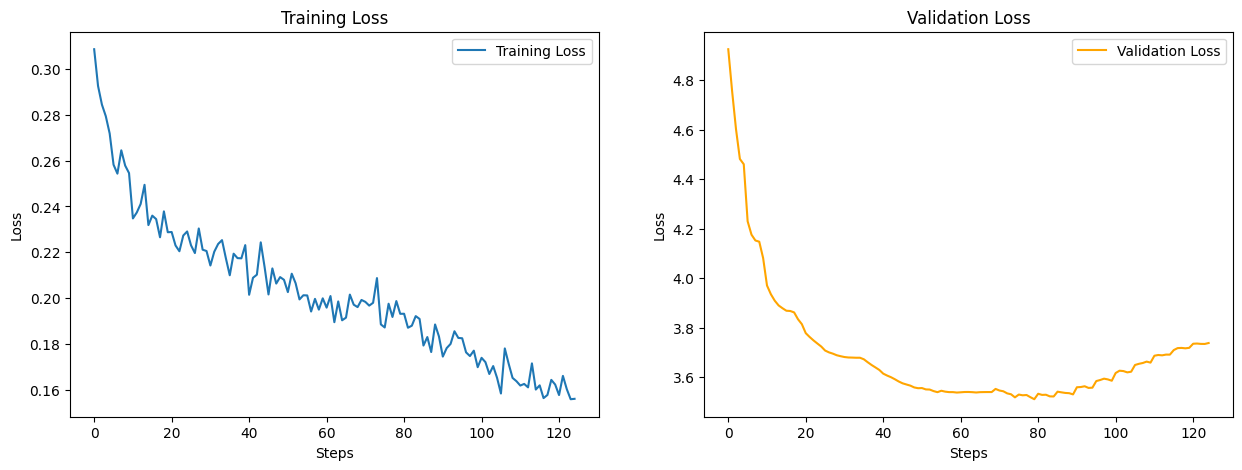

In [16]:
# plot losses curve
plot_losses(train_losses, val_losses)

In [17]:
# calculate perplexity on test set
perplexity = calculate_perplexity(model, test_loader, config)
print(f"Test Perplexity: {perplexity:.4f}")

Test Perplexity: 36.7973


In [19]:
# generate text with different decoding strategies
prompts = [
  "We are working on this new project",
  "Today is a great day for",
  "Let us do something fun today"
]

for p in prompts:
  # greedy decoding
  generated_text_greedy = generate_text(model, tokenizer, p, decoding_strategy="greedy")
  print(f"Greedy Decoding: {generated_text_greedy}")

  # top-k sampling
  generated_text_top_k = generate_text(model, tokenizer, p, decoding_strategy="top_k")
  print(f"Top-k Sampling: {generated_text_top_k}")

  print()

Greedy Decoding: We are working on this new project , that are the first to be the first , " The first two @-@ year " is to be the second and the second time of a second time . The first two in the second season of the season , " The series is the first time that
Top-k Sampling: We are working on this new project , the world ' s first , and the new production , has a major head book to be in North America . The world is an interview to his second game is for his other film work . It has been an average ( 25 @,@ 000 people )

Greedy Decoding: Today is a great day for the most common time is in the most common in the United States , and the most common time is in the United States . It has been used for its first time and in the United States , and in the United States .
Top-k Sampling: Today is a great day for the east of the population of four feet . It is a long two @-@ day single in the south and in the island , and American War . The largest in New Zealand , for other three of over 